<a href="https://colab.research.google.com/github/cepdnaclk/e19-co544-Bitcoin-Cost-Forecast-System/blob/main/Models/Multivariate_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [1]:
import yfinance as yf
import pandas as pd

# Define the ticker simbol for Bitcoin
ticker = 'BTC-USD'

# Get historical market data
hist = yf.Ticker(ticker).history(period="max")

# Making the 'Date' as the index
hist.index = pd.to_datetime(hist.index)

# Drop the "Dividends" column and "Stock Splits" column
hist.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)

# Print the data
print(hist.head())

                                 Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  
Date                                 
2014-09-17 00:00:00+00:00  21056800  
2014-09-18 00:00:00+00:00  34483200  
2014-09-19 00:00:00+00:00  37919700  
2014-09-20 00:00:00+00:00  36863600  
2014-09-21 00:00:00+00:00  26580100  


# Set Inputs and Outputs

In [2]:
X, y = hist.drop(columns = ['Close']), hist.Close.values
X.shape, y.shape

((3542, 4), (3542,))

## Standardize Features

In [3]:
# Import the StandardScaler and MinMaxScaler classes from the sklearn.preprocessing module
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Create an instance of thee MinMaxScaler, which scales the data to a specified range (default is 0 to 1)
mm = MinMaxScaler()

# Creating an instance of the standardScaler, which standardizes the data by removing the mean and scaling to unit variance
ss = StandardScaler()

# Applying the StandardScaler to the feature matrix X to standardize the features
# fit_transform() first fits the scaler to the data (calculating the mean and standard deviation) and then transforms the data
X_trans = ss.fit_transform(X)

# Reshaping the target variable y to be a 2D array with one column, as required by the MinMaxScaler
# fit_transform() first fits the scaler to the data (calculating the min and max values) and then transforms the data
y_trans = mm.fit_transform(y.reshape(-1, 1))

## Split a multivariate sequence past, future samples (X abd y)

In [4]:
import numpy as np

# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):

    X, y = list(), list() # instantiate X and y

    for i in range(len(input_sequences)):

        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break

        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)

    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 1)
print(X_ss.shape, y_mm.shape)

(3443, 100, 4) (3443, 1)


## Check the y_mm sample

In [5]:
print("y_mm[0]:", y_mm[0])
print("y_trans[99:100].squeeze(1):", y_trans[99:100].squeeze(1))

assert y_mm[0].all() == y_trans[99:100].squeeze(1).all()

y_mm[0]

y_mm[0]: [0.00193271]
y_trans[99:100].squeeze(1): [0.00193271]


array([0.00193271])

In [6]:
y_trans[99:100].squeeze(1)

array([0.00193271])

## Split Training & Test Sets

In [7]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-101]
X_test = X_ss[-101:]

y_train = y_mm[:-101]
y_test = y_mm[-101:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (3342, 100, 4) (3342, 1)
Testing Shape: (101, 100, 4) (101, 1)


## Convert Data Into Tensors

In [8]:
import torch

# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train).requires_grad_(True)
X_test_tensors = torch.Tensor(X_test).requires_grad_(True)

y_train_tensors = torch.Tensor(y_train).requires_grad_(True)
y_test_tensors = torch.Tensor(y_test).requires_grad_(True)


## Reshaping to rows, timestamps, features

In [9]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 100,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([3342, 100, 4]) torch.Size([3342, 1])
Testing Shape: torch.Size([101, 100, 4]) torch.Size([101, 1])


In [10]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 1)
X_check[-1][0:4]

X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2024-01-01 00:00:00+00:00,42280.234375,44175.437500,42214.976562,18426978443
2024-01-02 00:00:00+00:00,44187.140625,45899.707031,44176.949219,39335274536
2024-01-03 00:00:00+00:00,44961.601562,45503.242188,40813.535156,46342323118
2024-01-04 00:00:00+00:00,42855.816406,44770.023438,42675.175781,30448091210


In [ ]:
y_check[-1]

array([71631.359375  , 69139.015625  , 70587.8828125 , 70060.609375  ,
       67195.8671875 , 63821.47265625, 65738.7265625 , 63426.2109375 ,
       63811.86328125, 61276.69140625, 63512.75390625, 63843.5703125 ,
       64994.44140625, 64926.64453125, 66837.6796875 , 66407.2734375 ,
       64276.8984375 , 64481.70703125, 63755.3203125 , 63419.140625  ,
       63113.23046875, 63841.12109375, 60636.85546875, 58254.01171875,
       59123.43359375, 62889.8359375 , 63891.47265625, 64031.1328125 ,
       63161.94921875, 62334.81640625, 61187.94140625, 63049.9609375 ,
       60792.77734375, 60793.7109375 , 61448.39453125, 62901.44921875,
       61552.7890625 , 66267.4921875 , 65231.58203125, 67051.875     ,
       66940.8046875 , 66278.3671875 , 71448.1953125 , 70136.53125   ,
       69122.3359375 , 67929.5625    , 68526.1015625 , 69265.9453125 ,
       68518.09375   , 68542.1171875 ])

In [11]:
hist.Close.values[-1:]

array([67977.40625])

# LSTM Model

In [12]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

# Training

In [13]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

# Instance of a LSTM Model

In [14]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

# Training Loop (MSE as the loss function)

In [15]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)



Epoch: 0, train loss: 0.21291, test loss: 1.11813
Epoch: 100, train loss: 0.05121, test loss: 0.46580
Epoch: 200, train loss: 0.01929, test loss: 0.26601
Epoch: 300, train loss: 0.00180, test loss: 0.00575
Epoch: 400, train loss: 0.00072, test loss: 0.00224
Epoch: 500, train loss: 0.00014, test loss: 0.00119
Epoch: 600, train loss: 0.00007, test loss: 0.00062
Epoch: 700, train loss: 0.00005, test loss: 0.00054
Epoch: 800, train loss: 0.00005, test loss: 0.00056
Epoch: 900, train loss: 0.00005, test loss: 0.00053


# Prediction

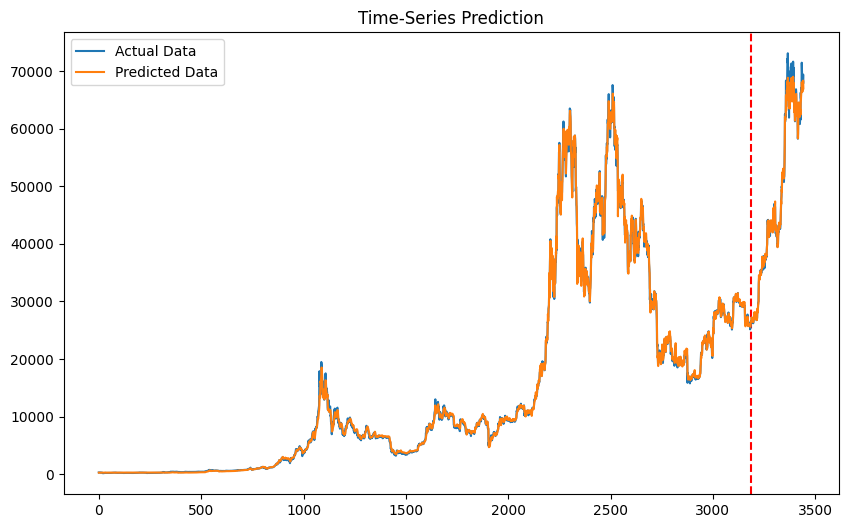

[66981.48]


In [16]:
import matplotlib.pyplot as plt

df_X_ss = ss.transform(hist.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(hist.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 1)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation

dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

print(preds[-1:])

# Bitcoin Price for Tommorrow

In [17]:
# Assuming df_X_ss and lstm are already defined and lstm is trained
# Get the last batch of the recent 100 days data
last_batch = df_X_ss[-1].reshape((1, 100, df_X_ss.shape[2]))

# Convert to tensor
last_batch_tensor = torch.Tensor(last_batch)

# Get the prediction
with torch.no_grad():
    lstm.eval()
    predicted_price_tensor = lstm(last_batch_tensor)
    predicted_price_numpy = predicted_price_tensor.data.numpy()

# Reverse the MinMax scaling
predicted_price = mm.inverse_transform(predicted_price_numpy)
print(f"Predicted Bitcoin price for tomorrow: {predicted_price[0][0]}")

Predicted Bitcoin price for tomorrow: 66981.4765625


# Model Evaluation

## RMSE

In [18]:
import torch

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        predictions = model(X_test)
        # Calculate the RMSE loss
        mse = torch.mean((predictions - y_test)**2)  # Calculate mean squared error
        rmse = torch.sqrt(mse)  # Calculate the square root of the MSE to get RMSE
    return rmse.item()  # Return RMSE value

# Call the evaluate_model function
test_rmse = evaluate_model(lstm, X_test_tensors_final, y_test_tensors)
print(f"Test RMSE: {test_rmse}")


Test RMSE: 0.022388571873307228


## Test Loss

In [19]:
import torch

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        predictions = model(X_test)
        # Calculate the loss
        loss_fn = torch.nn.MSELoss()
        loss = loss_fn(predictions, y_test)
    return loss.item()

# Call the evaluate_model function
test_loss = evaluate_model(lstm, X_test_tensors_final, y_test_tensors)
print(f"Test Loss: {test_loss}")


Test Loss: 0.0005012481124140322


## MAE

In [20]:
import torch
from torch.nn.functional import l1_loss

# 'predictions' and 'true_values' are PyTorch tensors of the same shape
predictions = lstm(X_test_tensors_final)
true_values = y_test_tensors

# Calculate MAE
mae = l1_loss(predictions, true_values, reduction='mean').item()
print(f"Mean Absolute Error: {mae}")



Mean Absolute Error: 0.017877081409096718


## R-squared

In [21]:
from sklearn.metrics import r2_score

# lstm and X_test_tensors_final are already defined and lstm is trained
lstm.eval()  # Set the model to evaluation mode
y_pred = lstm(X_test_tensors_final)
y_pred_numpy = y_pred.data.numpy()

# y_test_tensors is the actual values tensor and mm is the MinMaxScaler
y_test_numpy = y_test_tensors.data.numpy()

# Inverse transform the scaled data to original scale
y_pred_rescaled = mm.inverse_transform(y_pred_numpy)
y_test_rescaled = mm.inverse_transform(y_test_numpy)

# Calculate R-squared
r_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared: {r_squared}")




R-squared: 0.902178113624038


## MAPE

In [22]:
import torch

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps=1e-8):
    # Avoid division by zero
    y_true, y_pred = torch.tensor(y_true), torch.tensor(y_pred)
    mape = torch.mean(torch.abs((y_true - y_pred) / torch.clamp(y_true, min=eps)))
    return mape

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        predictions = model(X_test)
        # Calculate the MAPE
        mape = mean_absolute_percentage_error(y_test, predictions)
    return mape.item()

# Call the evaluate_model function
test_mape = evaluate_model(lstm, X_test_tensors_final, y_test_tensors)
print(f"Test MAPE: {test_mape}")


Test MAPE: 0.019540103152394295
